In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas_datareader as web
import datetime as dt
import yfinance as yf

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.layers import GRU

Download Tesla stock data from Yahoo Finance

In [137]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2023, 1, 1)
tesla_data = yf.download('TSLA', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


data exploration 

In [138]:
tesla_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2015-01-02,14.620667,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.041333,14.253333,14.000667,14.187333,51637500


In [141]:
tesla_data.shape

(2014, 6)

In [111]:
tesla_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2014 entries, 2015-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, TSLA)  2014 non-null   float64
 1   (Close, TSLA)      2014 non-null   float64
 2   (High, TSLA)       2014 non-null   float64
 3   (Low, TSLA)        2014 non-null   float64
 4   (Open, TSLA)       2014 non-null   float64
 5   (Volume, TSLA)     2014 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 110.1 KB


In [112]:
tesla_data['Volume'] = tesla_data['Volume']

prepare  data for training by scaling the Close prices

In [113]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tesla_data[['Close', 'Volume']].values)

Plot the correlation matrix using a heatmap

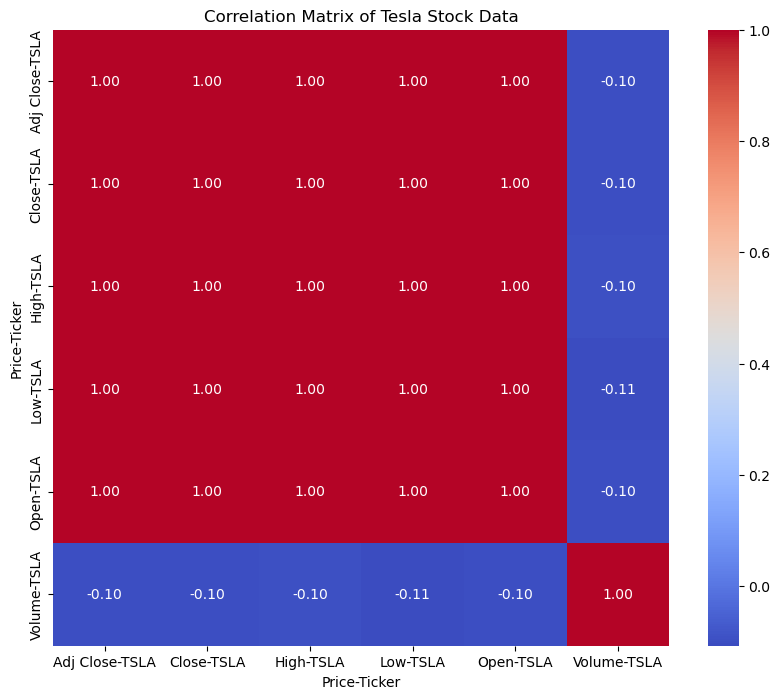

In [114]:
correlation_matrix = tesla_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Tesla Stock Data')
plt.show()

Plot the closing prices of Tesla stock over time

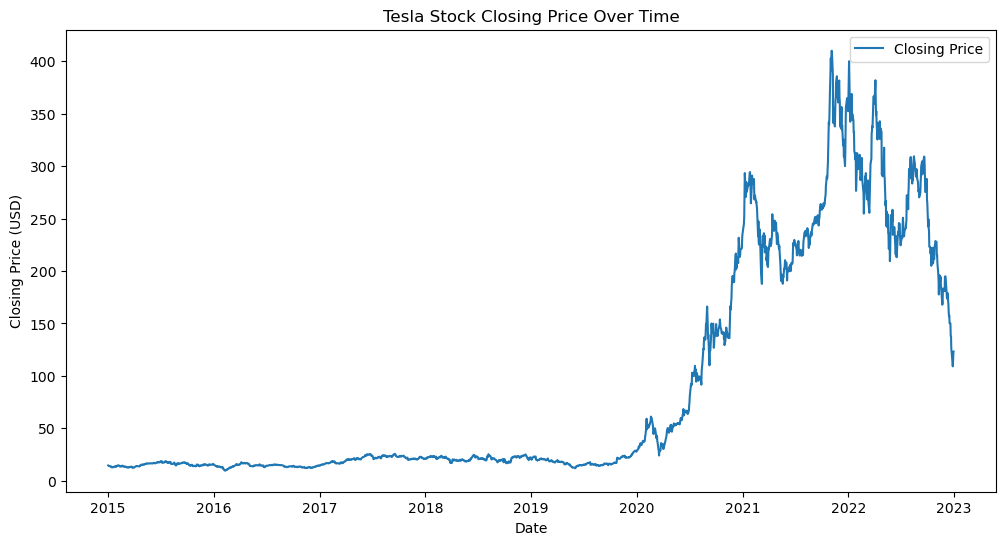

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(tesla_data['Close'], label='Closing Price')
plt.title('Tesla Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()


boxplot to show the distribution of stock prices and detect outliers

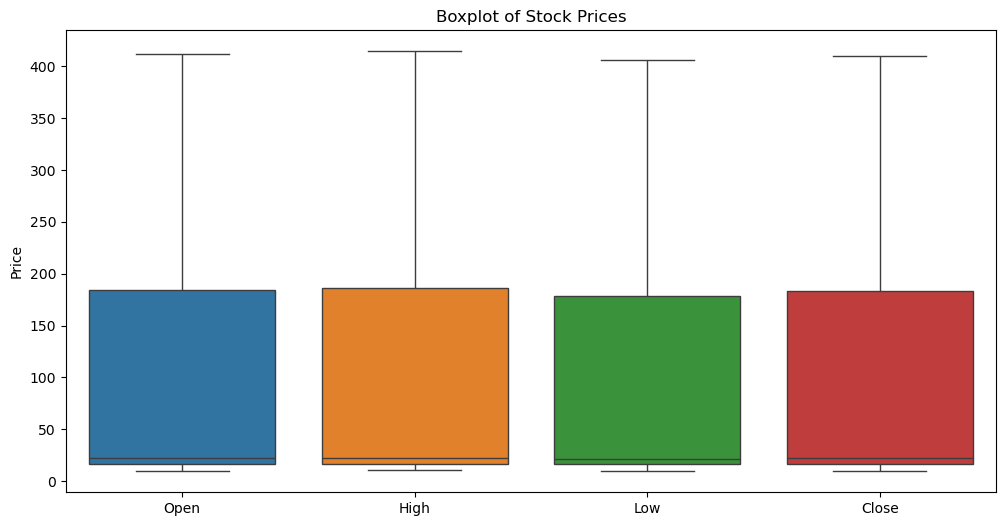

In [116]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=tesla_data[['Open', 'High', 'Low', 'Close']])
plt.title('Boxplot of Stock Prices')
plt.ylabel('Price')
plt.show()

 number of days for predicting future prices

In [117]:
prediction_days=100

In [118]:
x_train=[]
y_train=[]

Create the training datase

In [ ]:
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, :])
    y_train.append(scaled_data[x, 0])  

In [120]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
print("Length of x_train:", len(x_train))  
print("Shape of x_train before reshape:", np.array(x_train).shape)


Length of x_train: 1914
Shape of x_train before reshape: (1914, 100, 2)


In [122]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))  

training the model

In [123]:
model=Sequential()

In [124]:
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=100))
model.add(Dropout(0.2))

model.add(Dense(units=1))

c:\Users\micha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [125]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 0.0288
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0016
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0017
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0018
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0015
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0012
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 9.4507e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0013
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0012
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0012


 Define the testing period 

In [126]:
test_start = dt.datetime(2023, 2, 2)
test_end = dt.datetime(2024, 2, 2)
test_tesla_data = yf.download('TSLA', start=test_start, end=test_end)
test_data = test_tesla_data[['Close', 'Volume']]


[*********************100%***********************]  1 of 1 completed


In [127]:
total_dataset = pd.concat((tesla_data[['Close', 'Volume']], test_data), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = scaler.transform(model_inputs)


 Create the test dataset

In [140]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, :])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))

In [139]:
predicted_price = model.predict(x_test)
predicted_price = scaler.inverse_transform(np.concatenate((predicted_price, np.zeros_like(predicted_price)), axis=1))[:, 0] 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [132]:
actual_prices = test_tesla_data['Close'].values
mae = mean_absolute_error(actual_prices, predicted_price)
mse = mean_squared_error(actual_prices, predicted_price)
rmse = np.sqrt(mse)

In [133]:
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 10.265508248986476
Mean Squared Error: 197.51978119233723
Root Mean Squared Error: 14.054173088173393


 Plot the actual prices vs predicted prices

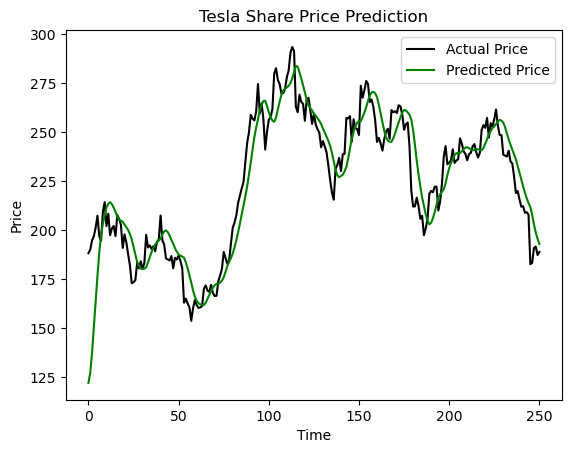

In [134]:
plt.plot(actual_prices, color='black', label='Actual Price')
plt.plot(predicted_price, color='green', label='Predicted Price')
plt.title("Tesla Share Price Prediction")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [136]:

model.save('tesla_stock_price_prediction_model.keras')
print("Model saved as tesla_stock_price_prediction_model.keras")


Model saved as tesla_stock_price_prediction_model.keras
